# Basic pendulum animations: using %matplotlib notebook

Use Pendulum class to generate basic pendulum animations.  Uses the `%matplotlib notebook` backend for Jupyter notebooks to display the animation as real-time updates with `animation.FuncAnimation` (as opposed to making a movie, see the pendulum_animation_notebook_inline versions for an alternative).

Version v2 adds a class for the animation.  Only one pendulum animated in this version.
Version v3 allows for more than one pendulum.

* v3: Created 27-Jan-2019. Last revised 29-Jan-2019 by Dick Furnstahl (furnstahl.1@osu.edu).
* v2: Created 27-Jan-2019. Last revised 27-Jan-2019 by Dick Furnstahl (furnstahl.1@osu.edu).
* v1: Created 25-Jan-2019. Last revised 27-Jan-2019 by Dick Furnstahl (furnstahl.1@osu.edu).

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class DuffingEq():
    """
    DuffingEq class implements the parameters and differential equation for 
     a pendulum using the notation from Taylor.
     
    Parameters
    ----------
    omega_0 : float
        natural frequency of the pendulum (\sqrt{g/l} where l is the 
        pendulum length) 
    beta : float
        coefficient of friction 
    gamma_ext : float
        amplitude of external force is gamma * omega_0**2 
    omega_ext : float
        frequency of external force 
    phi_ext : float
        phase angle for external force 

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    driving_force(t) 
        Returns the value of the external driving force at time t.
    """
    def __init__(self, omega_0=1., beta=0.2,
                 gamma_ext=0.2, omega_ext=0.689, phi_ext=0.
                ):
        self.omega_0 = omega_0
        self.beta = beta
        self.gamma_ext = gamma_ext
        self.omega_ext = omega_ext
        self.phi_ext = phi_ext
    
    def dy_dt(self, y, t):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        y : float
            A 2-component vector with y[0] = phi(t) and y[1] = dphi/dt
        t : float
            time 
            
        Returns
        -------
        
        """
        F_ext = self.driving_force(t)
        return [y[1], -self.omega_0**2 * np.sin(y[0]) - 2.*self.beta * y[1] \
                       + F_ext]
    
    def driving_force(self, t):
        """
        This function returns the value of the driving force at time t.
        """
        return self.gamma_ext * self.omega_0**2 \
                              * np.cos(self.omega_ext*t + self.phi_ext)  
    
    def solve_ode(self, t_pts, phi_0, phi_dot_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given the array of time points and initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_0, phi_dot_0]  
        phi, phi_dot = odeint(self.dy_dt, y, t_pts, 
                              atol=abserr, rtol=relerr).T
        return phi, phi_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    """Given an array (e.g., of times) and desired starting and stop values,
        return the array indices that are closest to those values.
    """
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## AnimationPendulumPlot class

In [7]:
class AnimationPendulumPlot():
    """
    AnimationPlot class uses matplotlib.animation.FuncAnimation to animate
     the dynamics of an oscillator.  This includes a simple time dependence
     graph, a state space graph with Poincare map, and a physical model.
     
     We'll start with a pendulum and then generalize later.
     
    Parameters
    ----------
    phi_vs_t : boolean
        If True, plot phi(t) vs. t
    
    phi_dot_vs_t : boolean
        If True, plot phi_dot(t) vs. t
    
    state_space : boolean
        If True, plot phi_dot(t) s. phi(t)
    
    physics_pend : boolean
        If True, draw the pendulum at phi(t) vs. t


    Methods
    -------
    plot_setup
    
    t_pts_init
    
    add_pendulum
    
    animate_pendulum
    
    plot_setup
    
    start_animation
    """
    def __init__(self, phi_vs_t=True, phi_dot_vs_t=False,
                 state_space=True, physical_pend=True):
        self.phi_list = []
        self.phi_dot_list = []
        self.length = 0.8
        self.line_colors = ['blue', 'red']
        self.pt_colors = ['black', 'brown']
        self.phi_align = ['left', 'right']
                  
    def t_pts_init(self, t_start=0., t_end=100., delta_t=0.01): 
        """Create the array of time points for the full iteration"""
        self.t_start = t_start
        self.t_end = t_end
        self.delta_t = delta_t
        self.t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    def add_pendulum(self, pend, phi_0=0., phi_dot_0=0.):
        """Add a pendulum to be plotted as a class instance of Pendulum
            along with initial conditions.  So it knows all of the parameters
            as well through the Pendulum class.
        """
        self.pend = pend
        phi, phi_dot = pend.solve_ode(self.t_pts, phi_0, phi_dot_0)
        self.phi_list.append(phi)
        self.phi_dot_list.append(phi_dot)
    
    def plot_setup(self, plot_start, plot_end):
        """Set up the plots to be displayed. """

            # start the plot!
#         overall_title = 'Parameters:  ' + \
#                         rf' $\omega = {omega_ext:.2f},$' + \
#                         rf' $\gamma = {gamma_ext:.3f},$' + \
#                         rf' $\omega_0 = {omega_0:.2f},$' + \
#                         rf' $\beta = {beta:.2f},$' + \
#                         rf'  $\phi_0 = {phi_0:.2f},$' + \
#                         rf' $\dot\phi_0 = {phi_dot_0:.2f}$' + \
#                         '\n'     # \n means a new line (adds some space here)
#         self.fig = plt.figure(figsize=(10,3.3), num='Pendulum Plots')
#         self.fig.suptitle(overall_title, va='top')

        # Labels for individual plot axes
        phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
        phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
        state_space_labels = (r'$\phi$', r'$d\phi/dt$')
        
        self.fig = plt.figure(figsize=(10, 3.3), num='Pendulum animation')

        self.ax_1 = self.fig.add_subplot(1,3,1)        
        self.ax_1.set_xlabel(r'$t$')
        self.ax_1.set_ylabel(r'$\phi(t)$')
        self.line_1 = []
        self.pt_1 = []

        self.ax_2 = self.fig.add_subplot(1,3,2, projection='polar')
        self.ax_2.set_aspect(1)   # aspect ratio 1 subplot
        self.ax_2.set_rorigin(0.)   # origin in the middle
        self.ax_2.set_theta_zero_location('S')  # phi=0 at the bottom
        self.ax_2.set_ylim(-1.,1.)  # r goes from 0 to 1
        self.ax_2.grid(False)   # no longitude/lattitude lines
        self.ax_2.set_xticklabels([])   # turn off angle labels
        self.ax_2.set_yticklabels([])    # turn off radial labels
        self.ax_2.spines['polar'].set_visible(False) # no circular border
        self.line_2 = []
        self.pt_2 = []
        self.phi_text = []

        self.ax_3 = self.fig.add_subplot(1,3,3)
        self.ax_3.set_xlabel(r'$\phi$')
        self.ax_3.set_ylabel(r'$\dot\phi$')
        self.line_3 = []
        self.pt_3 = []
       
        
        # plot new arrays from start to stop
        self.start, self.stop = start_stop_indices(self.t_pts, plot_start, 
                                                   plot_end)
        self.t_pts_plt = self.t_pts[self.start : self.stop]
        self.phi_plt_list = []
        self.phi_dot_plt_list = []
        for i, (phi, phi_dot) in enumerate(zip(self.phi_list, 
                                               self.phi_dot_list)):
            phi_plt = phi[self.start : self.stop]
            self.phi_plt_list.append(phi_plt)
            
            phi_dot_plt = phi_dot[self.start : self.stop]
            self.phi_dot_plt_list.append(phi_dot_plt)

            line_1, = self.ax_1.plot(self.t_pts_plt, phi_plt, 
                                      color=self.line_colors[i])
            self.line_1.append(line_1)
            pt_1, = self.ax_1.plot(self.t_pts_plt[0], phi_plt[0], 
                                    'o', color=self.pt_colors[i])
            self.pt_1.append(pt_1)
        
            self.ax_2.plot(0, 0, color='black', marker='o', markersize=5)
            line_2, = self.ax_2.plot([phi_plt[0], phi_plt[0]], 
                                      [0.,self.length], 
                                      color=self.line_colors[i], lw=3)
            self.line_2.append(line_2)
            pt_2, = self.ax_2.plot(phi_plt[0], self.length, 
                                   marker='o', markersize=15, 
                                   color=self.pt_colors[i])
            self.pt_2.append(pt_2)
            phi_string = rf'$\phi = {phi_plt[0]: .1f}$'
            phi_text = self.ax_2.text(np.pi, 1., phi_string, 
                                   horizontalalignment=self.phi_align[i]) 
            self.phi_text.append(phi_text)        
        
            line_3, = self.ax_3.plot(phi_plt, phi_dot_plt, 
                                     color=self.line_colors[i])
            self.line_3.append(line_3)
            pt_3, = self.ax_3.plot(phi_plt[0], phi_dot_plt[0], 
                                    'o', color=self.pt_colors[i])
            self.pt_3.append(pt_3)
        
        self.fig.tight_layout()
        

    def animate_pendulum(self, i, t_pts_skip, phi_skip_list,
                         phi_dot_skip_list):
        for index, (phi_skip, phi_dot_skip) in \
                     enumerate(zip(phi_skip_list, phi_dot_skip_list)):
            self.pt_1[index].set_data(t_pts_skip[i], phi_skip[i])

            self.line_2[index].set_data([phi_skip[i], phi_skip[i]], 
                                        [0., self.length])
            self.pt_2[index].set_data(phi_skip[i], self.length)
            phi_string = rf'$\phi = {phi_skip[i]: .1f}$  '
            self.phi_text[index].set_text(phi_string)

            self.pt_3[index].set_data(phi_skip[i], phi_dot_skip[i])

        #return self.pt_1, self.pt_2, self.phi_text, self.pt_3
          
        
    def start_animation(self, skip=2, interval=25.):
        self.skip = skip          # skip between points in t_pts array
        self.interval = interval  # time between frames in milliseconds
        
        phi_skip_list = []
        phi_dot_skip_list = []
        for i, (phi_plt, phi_dot_plt) in enumerate(zip(self.phi_plt_list, 
                                                       self.phi_dot_plt_list)):
            phi_skip_list.append(phi_plt[::self.skip])
            phi_dot_skip_list.append(phi_dot_plt[::self.skip])
                      
        t_pts_skip = self.t_pts_plt[::self.skip]                                   
        self.anim = animation.FuncAnimation(self.fig, self.animate_pendulum, 
                           fargs=(t_pts_skip,
                                  phi_skip_list, phi_dot_skip_list,
                                 ), 
                           init_func=None,
                           frames=len(t_pts_skip), 
                           interval=self.interval, 
                           blit=False, repeat=False,
                           save_count=0)

        #HTML(anim.to_jshtml())
        self.fig.show()


## Plots to animate

In [8]:
# Create a pendulum animation instance. 
pendulum_anim = AnimationPendulumPlot(phi_vs_t=True, 
                                      state_space=True,
                                      physical_pend=True)

# Common plotting time (generate the full time here then use slices below)
t_start = 0.
t_end = 100.
delta_t = 0.01
pendulum_anim.t_pts_init(t_start, t_end, delta_t)

# Pendulum parameters
gamma_ext = 1.084
omega_ext = 2.*np.pi
phi_ext = 0.
omega_0 = 1.5*omega_ext
beta = omega_0/4.

# Instantiate a pendulum 
p1 = Pendulum(omega_0=omega_0, beta=beta, 
              gamma_ext=gamma_ext, omega_ext=omega_ext, phi_ext=phi_ext)

# Initial conditions specified
phi_0 = 0.0; -np.pi / 2.  # 0.0
phi_0p = phi_0 + 0.0001
phi_dot_0 = 0.0

# Add a pendulum to the animation plots; this solves the differential
#  equation for the full t_pts array, generating phi and phi_dot internally. 
pendulum_anim.add_pendulum(p1, phi_0, phi_dot_0)
pendulum_anim.add_pendulum(p1, phi_0p, phi_dot_0)

NameError: name 'Pendulum' is not defined

<IPython.core.display.Javascript object>


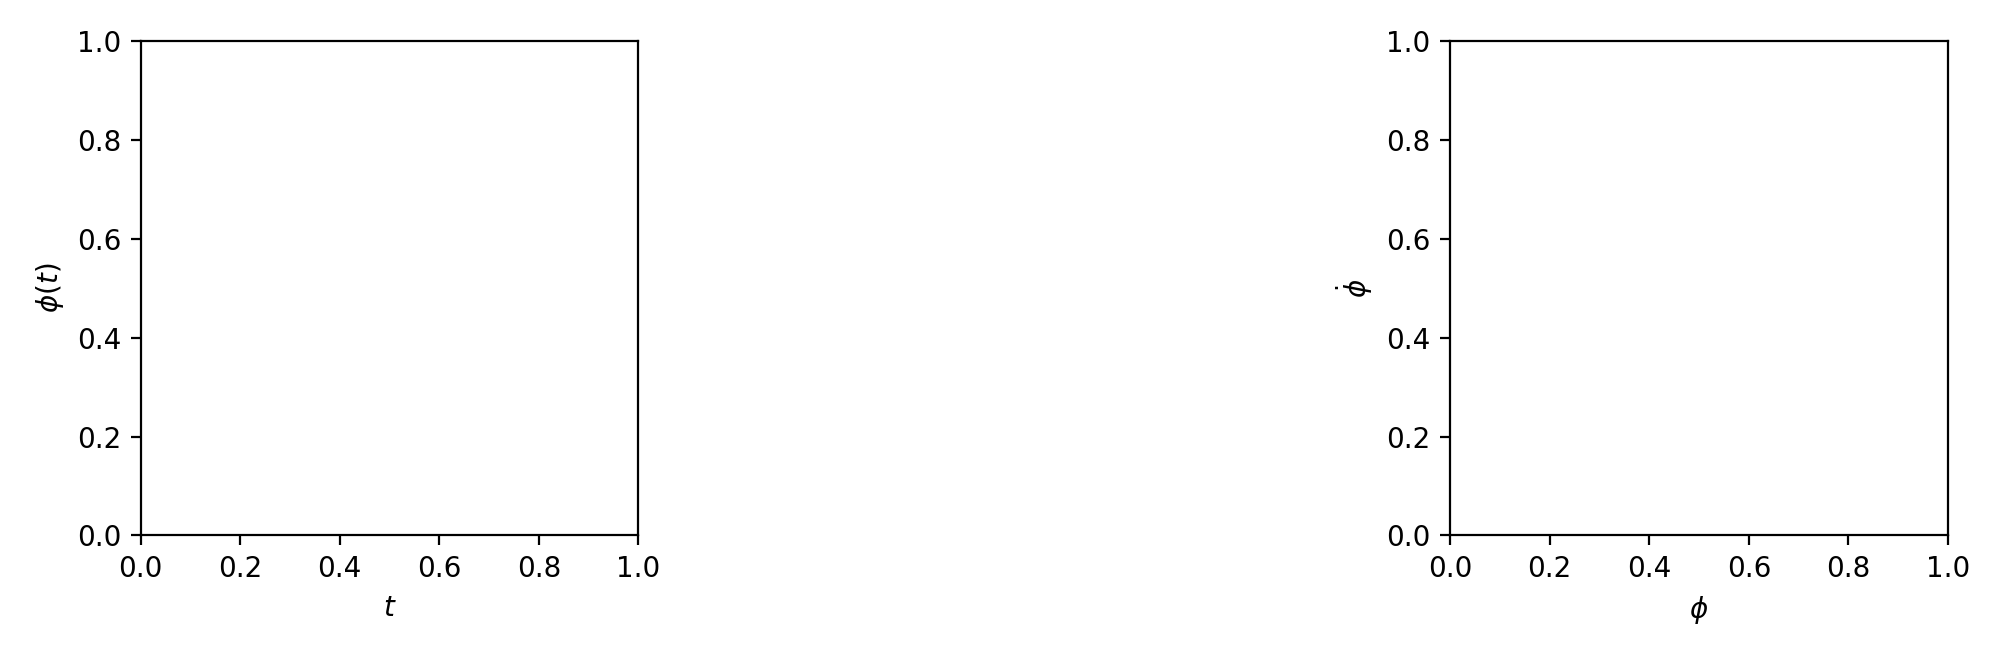

In [9]:
plot_start = 0.   # time to begin plotting
plot_end = 30.    # time to end plotting
pendulum_anim.plot_setup(plot_start, plot_end)

# Start the animation (adjust skip and interval for a smooth plot at a 
#  useful speed)
skip = 2        # skip between time points (in units of delta_t) 
interval = 15.  # time between frames in milliseconds
pendulum_anim.start_animation(skip, interval)